<a href="https://colab.research.google.com/github/idevede/-_-/blob/master/Random_sample_Coupled_Fourier_Gray_Scott.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from scipy.io import loadmat, savemat

In [ ]:
# Define functions
import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial

# Utilities

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size()))
    return c


## 1.2. FNO

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer

torch.manual_seed(0)
np.random.seed(0)


#  1d fourier layer

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):

        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Coupled

ntrain = 1000
ntest = 200

sub = 2**2 #subsampling rate
h = 2**10 // sub #total grid size divided by the subsampling rate
s = h


batch_size = 20

rw_ = loadmat('/content/drive/MyDrive/darcy_flow/Gray_scott_u_l2l5_rand_grf.mat')
x_data = rw_['input_u_N'].astype(np.float32)
y_data = rw_['output_u_N'].astype(np.float32)
print(x_data.shape)

x_train = x_data[:ntrain,::sub]
y_train = y_data[:ntrain,::sub]
x_test = x_data[-ntest:,::sub]
y_test = y_data[-ntest:,::sub]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

learning_rate = 0.001

x_train = x_train.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)

# cat the locations information
grid = np.linspace(0, 1, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)

x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

print(x_train.shape)
print(x_test.shape)

train_loader_1 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

test_loader_1 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

(1000, 1024)
torch.Size([1000, 256, 2])
torch.Size([200, 256, 2])


In [ ]:
# Coupled

ntrain = 1000
ntest = 200

sub = 2**2 #subsampling rate
h = 2**10 // sub #total grid size divided by the subsampling rate
s = h


batch_size = 20

rw_ = loadmat('/content/drive/MyDrive/darcy_flow/Gray_scott_v_l2l5_rand_grf.mat')
x_data = rw_['input_v_N'].astype(np.float32)
y_data = rw_['output_v_N'].astype(np.float32)
print(x_data.shape)

x_train = x_data[:ntrain,::sub]
y_train = y_data[:ntrain,::sub]
x_test = x_data[-ntest:,::sub]
y_test = y_data[-ntest:,::sub]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

learning_rate = 0.001

x_train = x_train.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)

# cat the locations information
grid = np.linspace(0, 1, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)

x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

print(x_train.shape)
print(x_test.shape)

train_loader_2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

test_loader_2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

(1000, 1024)
torch.Size([1000, 256, 2])
torch.Size([200, 256, 2])


In [ ]:
# model
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 16
width = 64

model1 = FNO1d(modes, width).cuda()
model2 = FNO1d(modes, width).cuda()
print(count_params(model1))
print(count_params(model2))

287489
287489


In [ ]:
################################################################
# training and evaluation
################################################################
import random

optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=step_size, gamma=gamma)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=step_size, gamma=gamma)

In [ ]:
error_1 = []
error_2 = []

myloss = LpLoss(size_average=False)

len_loader = ntrain/batch_size
print(len_loader)
grid = grid.cuda()

out1 = None
out2 = None

for ep in range(epochs):
    model1.train()
    model2.train()
    t1 = default_timer()
    # train_mse = 0
    train_l2_1 = 0
    train_l2_2 = 0

    flag_1 = 0
    flag_2 = 0

    out1_cat = 0
    out2_cat = 0

    while flag_1+flag_2 < 100:

      random_num = random.random()
      if random_num < 0.5:

        if flag_1 == len_loader:
          continue
        
        else:

          i_1 = 0
          cnt1 = 0
          for x, y in train_loader_1:
            if i_1 < flag_1:
              i_1 += 1
              continue

            x, y = x.cuda(), y.cuda()

            optimizer1.zero_grad()
    
            if out2 != None:
              out2_new = out2
              x_train1 = torch.cat([x, out2_new], dim=2)
            else:
              x_train1 = torch.cat([x, torch.zeros([batch_size,s,1]).cuda()], dim=2)
            out1 = model1(x_train1.detach())
            # mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            # mse.backward()

            l2_1 = myloss(out1.view(batch_size, -1), y.view(batch_size, -1))
            l2_1.backward() # use the l2 relative loss

            optimizer1.step()
            # train_mse += mse.item()
            train_l2_1 += l2_1.item()
            flag_1 += 1

            cnt1 += 1
            if cnt1 == 1:
              break


      else:
        if flag_2 == len_loader:
          continue

        else:
          i_2 = 0
          cnt2 = 0
          for x, y in train_loader_2:
            if i_2 < flag_2:
              i_2 += 1
              continue

            x, y = x.cuda(), y.cuda()

            optimizer2.zero_grad()

            if out1 != None:
              # out1_new = torch.cat([out1.reshape(batch_size,s,1), grid.repeat(batch_size,1,1)], dim=2)
              out1_new = out1
              x_train2 = torch.concat([x, out1_new], dim=2)
            else:
              x_train2 = torch.concat([x, torch.zeros([batch_size,s,1]).cuda()], dim=2)
    

            out2 = model2(x_train2.detach())
            # mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            # mse.backward()

            l2_2 = myloss(out2.view(batch_size, -1), y.view(batch_size, -1))
            l2_2.backward() # use the l2 relative loss

            optimizer2.step()
            # train_mse += mse.item()
            train_l2_2 += l2_2.item()
            flag_2 += 1

            cnt2 += 1
            if cnt2 == 1:
              break


    scheduler1.step()
    model1.eval()
    test_l2_1 = 0.0
    with torch.no_grad():
        for x, y in test_loader_1:
            x, y = x.cuda(), y.cuda()

            out1_test = model1(torch.concat([x, out2_new], dim=2))
            test_l2_1 += myloss(out1_test.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2_1 /= ntrain
    test_l2_1 /= ntest
    error_1.append(test_l2_1)

    scheduler2.step()
    model2.eval()
    test_l2_2 = 0.0
    with torch.no_grad():
        for x, y in test_loader_2:
            x, y = x.cuda(), y.cuda()

            out2_test = model2(torch.concat([x, out1_new], dim=2))
            test_l2_2 += myloss(out2_test.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2_2 /= ntrain
    test_l2_2 /= ntest
    error_2.append(test_l2_2)
    t2 = default_timer()
    print(ep, t2-t1,train_l2_1, test_l2_1, train_l2_2, test_l2_2)
# np.save('/content/drive/MyDrive/Fourier_data/Burgers/F1d_kdv_low_high_128_8192',error)
np.save('/content/drive/MyDrive/darcy_flow/Gray_scott_u_coupled2_rsamp_urand_vgrf',error_1)
np.save('/content/drive/MyDrive/darcy_flow/Gray_scott_v_coupled2_rsamp_urand_vgrf',error_2)


50.0
0 2.4034305329998915 0.8228976774215698 0.5631772994995117 0.38816447353363037 0.23770400524139404
1 1.6696503960001792 0.36207490491867067 0.30747721672058104 0.2309010968208313 0.23055505037307739
2 1.6804003899999316 0.21186887383460998 0.178012535572052 0.2184356417655945 0.24174938678741456
3 1.662756667000167 0.16712693405151366 0.1781388568878174 0.23205508303642272 0.22984272241592407
4 1.6449140400000033 0.1699444992542267 0.18000483989715577 0.22682890343666076 0.23886097192764283
5 1.6487862639999094 0.18182844805717469 0.16249141454696656 0.2227671458721161 0.23383984804153443
6 1.6482031549999192 0.16279401063919066 0.15771250128746034 0.2231841149330139 0.23042560815811158
7 1.6455422419999195 0.1695860742330551 0.1566395366191864 0.2274233477115631 0.228194739818573
8 1.6757468880000488 0.1666476604938507 0.1542883437871933 0.22811124181747436 0.22438642263412475
9 1.6712850159999562 0.16957492065429688 0.15397783875465393 0.22628020668029786 0.23099934935569763
10 

In [ ]:
error_1 = []
error_2 = []

myloss = LpLoss(size_average=False)

len_loader = ntrain/batch_size
print(len_loader)
grid = grid.cuda()
for ep in range(epochs):
    model1.train()
    model2.train()
    t1 = default_timer()
    # train_mse = 0
    train_l2_1 = 0
    train_l2_2 = 0

    flag_1 = 0
    flag_2 = 0
    out1 = None
    out2 = None

    out1_cat = 0
    out2_cat = 0

    while flag_1+flag_2 < 100:

      random_num = random.random()
      if random_num < 0.5:

        if flag_1 == len_loader:
          continue
        
        else:

          i_1 = 0
          cnt1 = 0
          for x, y in train_loader_1:
            if i_1 < flag_1:
              i_1 += 1
              continue

            x, y = x.cuda(), y.cuda()

            optimizer1.zero_grad()
    
            if out2 != None:
              out2_new = torch.cat([out2.reshape(batch_size,s,1), grid.repeat(batch_size,1,1)], dim=2)
              x_train1 = torch.cat([x, out2_new], dim=2)
            else:
              x_train1 = torch.cat([x, torch.zeros_like(x)], dim=2)
            out1 = model1(x_train1.detach())
            # mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            # mse.backward()

            l2_1 = myloss(out1.view(batch_size, -1), y.view(batch_size, -1))
            l2_1.backward() # use the l2 relative loss

            optimizer1.step()
            # train_mse += mse.item()
            train_l2_1 += l2_1.item()
            flag_1 += 1

            cnt1 += 1
            if cnt1 == 1:
              break


      else:
        if flag_2 == len_loader:
          continue

        else:
          i_2 = 0
          cnt2 = 0
          for x, y in train_loader_2:
            if i_2 < flag_2:
              i_2 += 1
              continue

            x, y = x.cuda(), y.cuda()

            optimizer2.zero_grad()

            if out1 != None:
              out1_new = torch.cat([out1.reshape(batch_size,s,1), grid.repeat(batch_size,1,1)], dim=2)
              x_train2 = torch.concat([x, out1_new], dim=2)
            else:
              x_train2 = torch.concat([x, torch.zeros_like(x)], dim=2)
    

            out2 = model2(x_train2.detach())
            # mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            # mse.backward()

            l2_2 = myloss(out2.view(batch_size, -1), y.view(batch_size, -1))
            l2_2.backward() # use the l2 relative loss

            optimizer2.step()
            # train_mse += mse.item()
            train_l2_2 += l2_2.item()
            flag_2 += 1

            cnt2 += 1
            if cnt2 == 1:
              break


    scheduler1.step()
    model1.eval()
    test_l2_1 = 0.0
    with torch.no_grad():
        for x, y in test_loader_1:
            x, y = x.cuda(), y.cuda()

            out1_test = model1(torch.concat([x, out2_new], dim=2))
            test_l2_1 += myloss(out1_test.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2_1 /= ntrain
    test_l2_1 /= ntest
    error_1.append(test_l2_1)

    scheduler2.step()
    model2.eval()
    test_l2_2 = 0.0
    with torch.no_grad():
        for x, y in test_loader_2:
            x, y = x.cuda(), y.cuda()

            out2_test = model2(torch.concat([x, out1_new], dim=2))
            test_l2_2 += myloss(out2_test.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2_2 /= ntrain
    test_l2_2 /= ntest
    error_2.append(test_l2_2)
    t2 = default_timer()
    print(ep, t2-t1,train_l2_1, test_l2_1, train_l2_2, test_l2_2)
# np.save('/content/drive/MyDrive/Fourier_data/Burgers/F1d_kdv_low_high_128_8192',error)


50.0
0 1.2949439140002141 0.33864840304851535 0.07450455844402314 0.4084939901828766 0.10628767430782318
1 1.6186388389996864 0.08629798948764801 0.09442903220653534 0.10201883089542389 0.07270498931407929
2 1.3128808510000454 0.08955925172567368 0.07144768714904785 0.08463878393173217 0.07363075256347656
3 1.2796940339994762 0.07495177614688874 0.08768206894397736 0.07044046568870545 0.05672555327415466
4 1.3137766579993695 0.08051423585414887 0.058920052647590634 0.0635792853832245 0.06066543817520142
5 1.3034324729997024 0.0757999797463417 0.0724741905927658 0.072188192486763 0.06942222833633423
6 1.3555811800006268 0.07761405664682389 0.07090205788612365 0.06957707071304321 0.06438804209232331
7 1.291906874000233 0.08215303176641464 0.06462823390960694 0.07190265130996704 0.06438719093799591
8 1.3242905589995644 0.07741421180963516 0.0612163108587265 0.06622875106334686 0.06031723022460937
9 1.3482713539997349 0.07963651084899902 0.07832824349403382 0.06528363287448884 0.0593912088

In [ ]:
np.save('/content/drive/MyDrive/darcy_flow/Gray_scott_u_coupled2_samp0',error_1)
np.save('/content/drive/MyDrive/darcy_flow/Gray_scott_v_coupled2_samp0',error_2)

In [ ]:
error_1 = []
error_2 = []

myloss = LpLoss(size_average=False)

len_loader = ntrain/batch_size
print(len_loader)

for ep in range(epochs):
    model1.train()
    model2.train()
    t1 = default_timer()
    # train_mse = 0
    train_l2_1 = 0
    train_l2_2 = 0

    flag_1 = 0
    flag_2 = 0
    out1 = None
    out2 = None

    out1_cat = 0
    out2_cat = 0

    while flag_1+flag_2 < 100:

      random_num = random.random()
      if random_num < 0.5:

        if flag_1 == len_loader:
          continue
        
        else:

          i_1 = 0
          cnt1 = 0
          for x, y in train_loader_1:
            if i_1 < flag_1:
              i_1 += 1
              continue

            x, y = x.cuda(), y.cuda()

            optimizer1.zero_grad()
    
            if out2 != None:
              x_train1 = torch.cat([x, out2], dim=2)
            else:
              x_train1 = torch.cat([x, torch.zeros_like(x)], dim=2)
            out1 = model1(x_train1.detach())
            # mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            # mse.backward()

            l2_1 = myloss(out1.view(batch_size, -1), y.view(batch_size, -1))
            l2_1.backward() # use the l2 relative loss

            optimizer1.step()
            # train_mse += mse.item()
            train_l2_1 += l2_1.item()
            flag_1 += 1

            cnt1 += 1
            if cnt1 == 1:
              break


      else:
        if flag_2 == len_loader:
          continue

        else:
          i_2 = 0
          cnt2 = 0
          for x, y in train_loader_2:
            if i_2 < flag_2:
              i_2 += 1
              continue

            x, y = x.cuda(), y.cuda()

            optimizer2.zero_grad()

            if out1 != None:
              x_train2 = torch.concat([x, out1], dim=2)
            else:
              x_train2 = torch.concat([x, torch.zeros_like(x)], dim=2)
    

            out2 = model2(x_train2.detach())
            # mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            # mse.backward()

            l2_2 = myloss(out2.view(batch_size, -1), y.view(batch_size, -1))
            l2_2.backward() # use the l2 relative loss

            optimizer2.step()
            # train_mse += mse.item()
            train_l2_2 += l2_2.item()
            flag_2 += 1

            cnt2 += 1
            if cnt2 == 1:
              break


    scheduler1.step()
    model1.eval()
    test_l2_1 = 0.0
    with torch.no_grad():
        for x, y in test_loader_1:
            x, y = x.cuda(), y.cuda()

            out1_test = model1(torch.concat([x, out2], dim=2))
            test_l2_1 += myloss(out1_test.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2_1 /= ntrain
    test_l2_1 /= ntest
    error_1.append(test_l2_1)

    scheduler2.step()
    model2.eval()
    test_l2_2 = 0.0
    with torch.no_grad():
        for x, y in test_loader_2:
            x, y = x.cuda(), y.cuda()

            out2_test = model2(torch.concat([x, out1], dim=2))
            test_l2_2 += myloss(out2_test.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2_2 /= ntrain
    test_l2_2 /= ntest
    error_2.append(test_l2_2)
    t2 = default_timer()
    print(ep, t2-t1,train_l2_1, test_l2_1, train_l2_2, test_l2_2)
# np.save('/content/drive/MyDrive/Fourier_data/Burgers/F1d_kdv_low_high_128_8192',error)


50.0
0 1.5205145559998527 0.31061482989788053 0.10580755412578582 0.33781771862506865 0.062312265932559965
1 1.5124738409999736 0.08402750635147095 0.07640580534934997 0.07586782598495484 0.06731726109981537
2 1.4710505379998722 0.07869409608840942 0.07620503902435302 0.06636938905715942 0.06325670301914216
3 1.4893864679997932 0.08468310558795929 0.07431402683258057 0.06968670207262039 0.05807612895965576
4 1.4780081560002145 0.07853405565023422 0.06802189230918884 0.0647981521487236 0.05533240258693695
5 1.452439133000098 0.07698172569274903 0.07043467223644256 0.06912797176837922 0.07166513085365295
6 1.4747138729999278 0.07779016375541686 0.0665630578994751 0.06746076023578644 0.05974387854337692
7 1.4842732970000725 0.07445740973949433 0.06424768805503846 0.06760250717401504 0.06692838579416276
8 1.5435708790000717 0.07501275807619096 0.0656958994269371 0.06453955966234207 0.06217111051082611
9 1.5128682630002004 0.08654603707790375 0.08370731115341186 0.07250386917591095 0.065544

In [ ]:
np.save('/content/drive/MyDrive/darcy_flow/Gray_scott_u_coupled2_sampout',error_1)
np.save('/content/drive/MyDrive/darcy_flow/Gray_scott_v_coupled2_sampout',error_2)

In [ ]:
error_u_coup_sample = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_u_coupled2_sampout.npy')
error_v_coup_sample = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_v_coupled2_sampout.npy')

error_base_u = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_u.npy')
error_base_v = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_v.npy') 

error_u_coup_1 = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_u_coupled1.npy')
error_v_coup_1 = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_v_coupled1.npy')

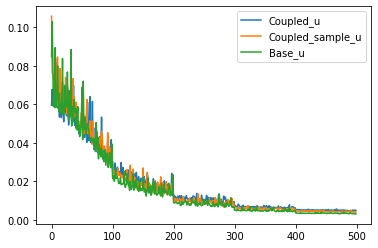

In [ ]:
plt.plot(error_u_coup_1, label = 'Coupled_u')
plt.plot(error_u_coup_sample, label = 'Coupled_sample_u')
# plt.plot(error_2, label = 'Coupledv')
plt.plot(error_base_u, label = 'Base_u')
# plt.plot(error_base_v, label = 'Basev')
plt.legend()

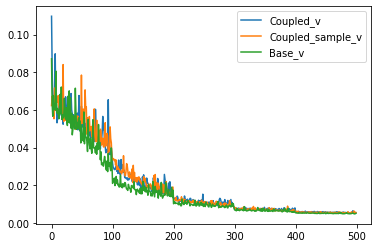

In [ ]:
plt.plot(error_v_coup_1, label = 'Coupled_v')
plt.plot(error_v_coup_sample, label = 'Coupled_sample_v')
# plt.plot(error_2, label = 'Coupledv')
plt.plot(error_base_v, label = 'Base_v')
# plt.plot(error_base_v, label = 'Basev')
plt.legend()

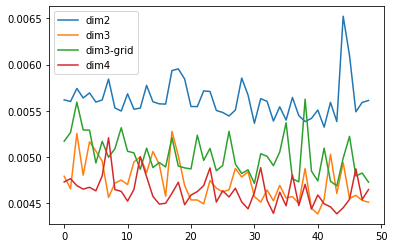

In [ ]:
error_u_coup_1 = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_v_coupled1.npy')
error_u_coup_sample =np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_v_coupled2_rsamp_dim3.npy')
a = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_v_coupled2_rsamp_dim3_grid.npy')
error_base_u = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_v_coupled2_rsamp_dim4.npy')

plt.plot(error_u_coup_1[-50:-1], label = 'dim2')
plt.plot(error_u_coup_sample[-50:-1], label = 'dim3')
plt.plot(a[-50:-1], label = 'dim3-grid')
# plt.plot(error_2, label = 'Coupledv')
plt.plot(error_base_u[-50:-1], label = 'dim4')
plt.legend()

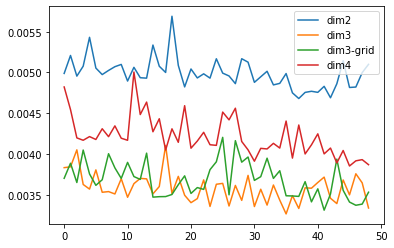

In [ ]:
error_u_coup_1 = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_u_coupled1.npy')
error_u_coup_sample =np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_u_coupled2_rsamp_dim3.npy')
a = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_u_coupled2_rsamp_dim3_grid.npy')
error_base_u = np.load('/content/drive/MyDrive/darcy_flow/Gray_scott_u_coupled2_rsamp_dim4.npy')

plt.plot(error_u_coup_1[-50:-1], label = 'dim2')
plt.plot(error_u_coup_sample[-50:-1], label = 'dim3')
plt.plot(a[-50:-1], label = 'dim3-grid')
# plt.plot(error_2, label = 'Coupledv')
plt.plot(error_base_u[-50:-1], label = 'dim4')
plt.legend()